In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn import linear_model, datasets, svm, metrics
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn import datasets
#from sklearn import svm
#from sklearn import metrics
import urllib2
from bs4 import BeautifulSoup
%matplotlib inline
train = pd.read_csv('train.csv')
train_sample = train.sample(train.shape[0]/2)
test = pd.read_csv('test.csv')

In [117]:
def remove_nas(dataframe, percent):
    null_data = dataframe.isnull().sum()
    data_to_remove = null_data[null_data > dataframe.shape[0]*percent].index.tolist()
    dataframe.drop(data_to_remove,1, inplace=True)
    return dataframe

In [73]:
def int_data(dataframe):
    data_type = dataframe.dtypes
    int_columns_1 = data_type[data_type=='int64'].index.tolist()
    int_columns_2 = data_type[data_type=='float64'].index.tolist()
    int_columns = int_columns_1 + int_columns_2
    int_dataframe = dataframe[int_columns]
    return int_dataframe

In [74]:
def process_data(dataframe):
    dataframe['TotalSF'] = dataframe['1stFlrSF'] + dataframe['2ndFlrSF']+ dataframe['TotalBsmtSF']
    dataframe.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'],1, inplace=True)
    return dataframe

def graph_processed_data(dataframe):
    var = [e for e in dataframe.columns.values.tolist() if e not in ('Id', 'SalePrice')]
    num_col = dataframe[var].shape[1]
    graph_dimension = int(round(math.sqrt(num_col)))

    f, ax = plt.subplots(graph_dimension, graph_dimension,figsize=(18,12))
    plt.subplots_adjust( hspace=0.3 )
    plt.subplots_adjust( wspace=0.04 )

    y = dataframe['SalePrice']
    counter = 0

    list_of_predictors =[]
    
    independent_var = dataframe[var]

    for i in range(graph_dimension):
        for j in range(graph_dimension):
            ax[i][j].get_yaxis().set_ticks([])
            ax[i][j].get_xaxis().set_ticks([])
            if counter >= num_col:
                continue
            else:
                x = independent_var.iloc[:, counter]
                ax[i][j].scatter(x,y)
                ax[i][j].set_title(independent_var.columns.values[counter])
            
                slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            
                if r_value**2 > 0.3:
                    list_of_predictors.append(independent_var.columns.values[counter])
                counter = counter + 1

    final_int_train = independent_var[list_of_predictors]
    return list_of_predictors, dataframe, final_int_train


In [75]:
def categorical_data(dataframe):
    dtype = dataframe.dtypes
    categories = dtype[dtype == 'object'].index.tolist()
    category_dataframe = dataframe[categories]
    return category_dataframe

/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


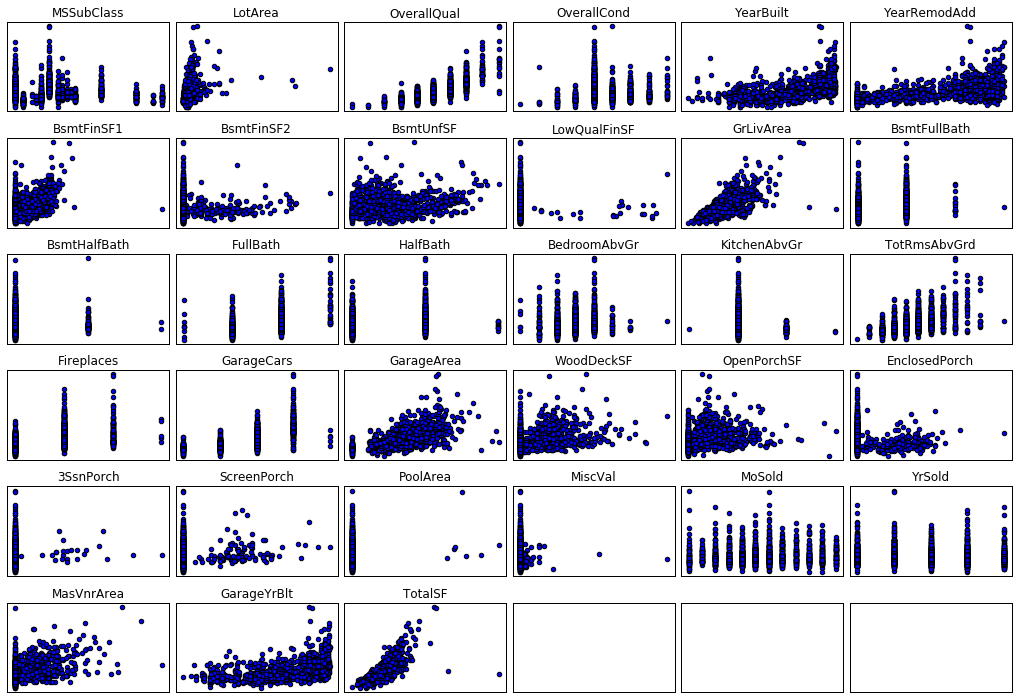

In [76]:
no_na_train = remove_nas(train, .10)
numerical_train = int_data(no_na_train)
process_train = process_data(numerical_train)
list_of_predictors_train, train, final_int_train = graph_processed_data(process_train)

In [132]:
#find categories that significantly effect sale price
cat = categorical_data(no_na_train)
cat = pd.get_dummies(cat)
cat['SalePrice']= no_na_train['SalePrice']
category_list = cat.columns.values.tolist()
sig_list = []
for c in category_list[:-1]:
    neg = cat.loc[cat[c] == 0]['SalePrice'].tolist()
    pos = cat.loc[cat[c] == 1]['SalePrice'].tolist()
    t, p = stats.ttest_ind(neg, pos, equal_var=False)
    if p <= 0.0005:
        sig_list.append(c)
print sig_list
final_cat_train = cat[sig_list]

['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_Reg', 'LandContour_Bnk', 'LotConfig_CulDSac', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_RRAe', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'RoofStyle_Gable', 'RoofStyle_Hip', 'Exterior1st_AsbShng', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior2nd_AsbShng', 'Exterior2nd_MetalSd'

In [78]:
no_na_test = remove_nas(test, .10)
numerical_test = int_data(no_na_test)
process_test = process_data(numerical_test)
cat_test = categorical_data(no_na_test)
cat_test = pd.get_dummies(cat_test)
cat_test_final = cat_test[sig_list]

/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [79]:
final_train = pd.concat([final_int_train,final_cat_train], axis = 1)


0.765285635737


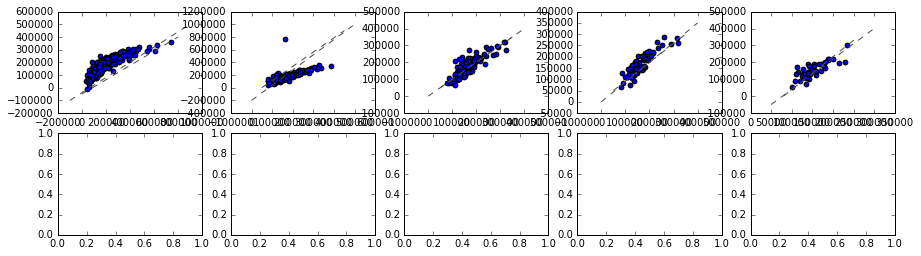

In [135]:
from sklearn import linear_model
x_train, x_test, y_train, y_test = train_test_split(final_int_train.values, train['SalePrice'].as_matrix(), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds = 5)

lr = linear_model.LinearRegression()
lr.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y = x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        lr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = lr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1
print lr.score(x_test, y_test)                           

0.841316369802


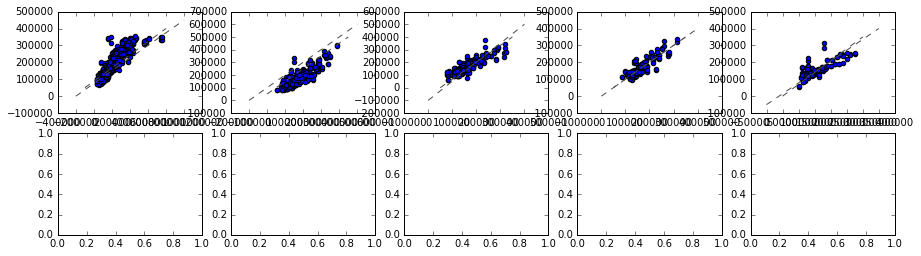

In [136]:
x_train, x_test, y_train, y_test = train_test_split(final_int_train.values, train['SalePrice'].as_matrix(), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=5)

rfr = RandomForestRegressor()
rfr.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        rfr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = rfr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1

print rfr.score(x_test, y_test)                           


0.0159817351598


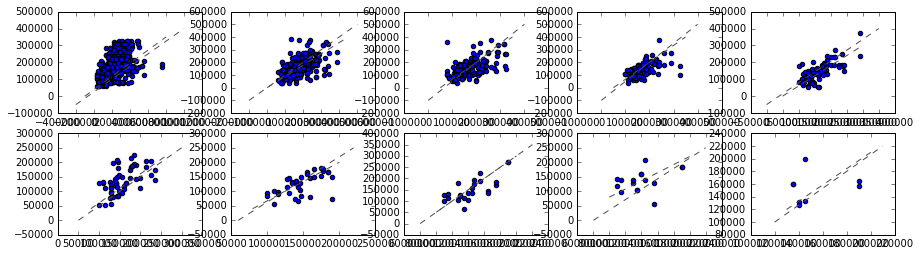

In [82]:
x_train, x_test, y_train, y_test = train_test_split(final_cat_train.values, train['SalePrice'].as_matrix(), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

rfc = RandomForestClassifier()
rfc.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        rfc.fit(val_train_x, val_train_y.ravel().T)
        y_pred = rfc.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1
print rfc.score(x_test, y_test)                           


0.013698630137


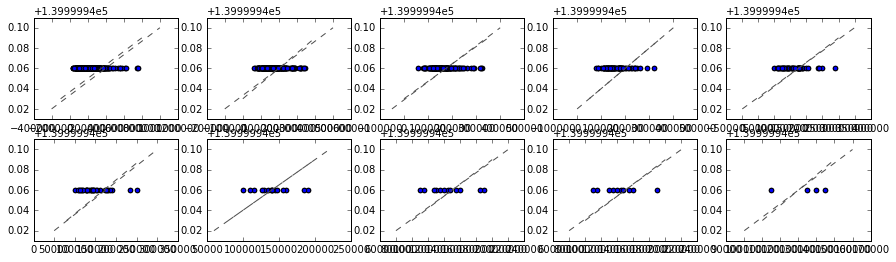

In [83]:
from sklearn import svm

x_train, x_test, y_train, y_test = train_test_split(final_cat_train.values, train['SalePrice'].as_matrix(), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

c = svm.SVC()
c.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        c.fit(val_train_x, val_train_y.ravel().T)
        y_pred = c.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1
print c.score(x_test, y_test)                           


0.00913242009132


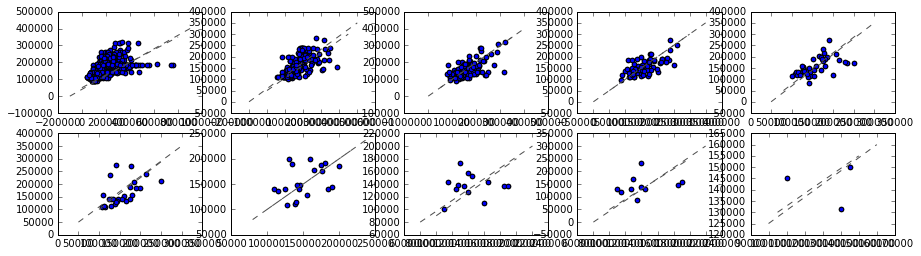

In [134]:
from sklearn.naive_bayes import GaussianNB

x_train, x_test, y_train, y_test = train_test_split(final_cat_train.values, train['SalePrice'].as_matrix(), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

gnb = GaussianNB()
gnb.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        gnb.fit(val_train_x, val_train_y.ravel().T)
        y_pred = gnb.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1
print gnb.score(x_test, y_test)                           


In [49]:
pred_t_int = rfr.predict(process_test[list_of_predictors_train])
pred_t_cat = gnb.predict(cat_test_final)
output_int = process_test[['Id']]
output_int['SalePrice']=pred_t_int
output_cat = process_test[['Id']]
output_cat['SalePrice'] = pred_t_cat
final_output = process_test[['Id']]
final_output['SalePrice'] = (output_int['SalePrice'] + output_cat['SalePrice'])/2
final_output = final_output.applymap(abs)
final_output.to_csv("prediction.csv",index=False)

/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [86]:
soup = BeautifulSoup(urllib2.urlopen(urllib2.Request("https://www.zillow.com/homes/recently_sold/MA/26_rid/0-599988_price/0-2224_mp/globalrelevanceex_sort/43.777044,-69.573669,40.256473,-73.797913_rect/7_zm/")).read())
all_url = []
for i in range(1,20):
    soup = BeautifulSoup(urllib2.urlopen(urllib2.Request("https://www.zillow.com/homes/recently_sold/MA/26_rid/0-599988_price/0-2224_mp/globalrelevanceex_sort/43.773077,-68.733215,40.25228,-74.638367_rect/7_zm/" + str(i) + "_p/")).read())
    for a in soup.find_all('a', href = True):
        if 'homedetails' in a['href']:
            all_url.append(a['href'])

/home/jen/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [87]:
dic={}
for url in all_url:
    soup = BeautifulSoup(urllib2.urlopen(urllib2.Request('https://www.zillow.com//' + str(url))).read())
    columns = soup.find_all('div', {'class' : 'hdp-fact-container-columns'})
    dic[url] = {}
    dic[url]['zipcode'] = soup.find('span', {'class': 'zsg-h2 addr_city'}).text
    for i in range(len(columns)):
        title = columns[i].find_all('div', {'class' : 'hdp-fact-container'})
        for t in range(len(title)):
            try:
                cat = title[t].find('span', {'class': 'hdp-fact-name'}).text
                value = title[t].find('span', {'class': 'hdp-fact-value'}).text
                dic[url][cat] = value
            except AttributeError:
                continue

In [95]:
df = pd.DataFrame.from_dict(dic)
df = df.transpose()
df.head()

,Accessibility:,Appliances included:,Basement:,BasementRoomsType:,Baths:,Beds:,Cooling:,Days on Zillow:,Electric Type:,Electric:,...,Structure type:,Style:,UnderConstruction:,Underground Oil Tank:,Unit count:,Unit floor #:,View:,Water:,Year Built Source:,zipcode
/homedetails/0-Old-Bridge-Rd-Hanover-MA-02339/2096421730_zpid/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hanover, MA 02339"
/homedetails/0-Queens-Circle-Raynham-MA-02767/2094630610_zpid/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Raynham, MA 02767"
/homedetails/00-Precinct-St-Middleboro-MA-02346/2094752300_zpid/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Middleboro, MA 02346"
/homedetails/1-19th-St-APT-5-Lowell-MA-01850/56508721_zpid/,NaN,"Dishwasher, Dryer, Microwave, Range / Oven, Re...",NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6,3,City,NaN,NaN,"Lowell, MA 01850"
/homedetails/1-Bisson-Ln-Merrimac-MA-01860/56944354_zpid/,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Merrimac, MA 01860"


In [116]:
n_df = remove_nas(df , .1)
n_df['Sold Price'] = 0
for i in n_df.index:
    try:
        index = n_df.loc[i , 'Last sold: '].index('$')
        string = n_df.loc[i , 'Last sold: '][index + 1:]
        num = int(string.replace(',' , ''))
        n_df.loc[i, 'Sold Price'] = num
        sqft = n_df.loc[i, 'Floor size: '].replace(' sqft', '')
        s = sqft.replace(',', '')
        n_df.loc[i, 'Floor size: '] = int(s)
    except (ValueError , KeyError, AttributeError):
        continue

Beds:           21
Floor size:     21
Last sold:       0
zipcode          0
Sold Price       0
dtype: int64


0.118591640657


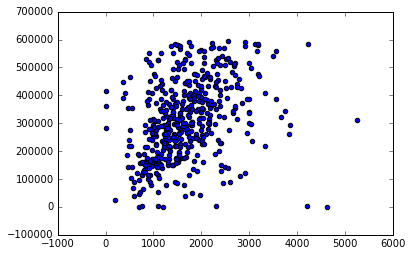

In [112]:
no_na = n_df.loc[(n_df['Floor size: '] >0) & (n_df['Sold Price'] >0)]
x = no_na['Floor size: '].tolist()
y = no_na['Sold Price'].tolist()
plt.scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print r_value**2

0.611930790204


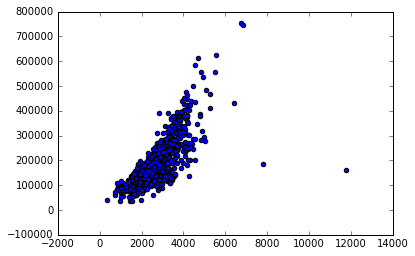

In [115]:
x = final_int_train['TotalSF']
y = train['SalePrice']
plt.scatter(x,y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print r_value**2